# 入力が連続の場合のHGF

HGFは知覚モデルになり、それに反応モデルを組み合わせて、行動からパラメータ推定を行います。以下では、入力が連続変数（ドル円レート）の場合のHGFについて、シミュレーションとパラメータ推定をします。以下の内容は、[HierarchicalGaussianFiltering.jlのtutorialの内容](hhttps://ilabcode.github.io/HierarchicalGaussianFiltering.jl/dev/)を参考に作成しています（2023/2/22に大幅アップデートがあり、充実しました）。

## 使用するJuliaパッケージ

[HierarchicalGaussianFiltering.jl](https://github.com/ilabcode/HierarchicalGaussianFiltering.jl)は以前はHGF.jlだったのですが、2022年の秋くらいに変更になりました。それ以前の資料は古い書き方な可能性があります。今後も変更が生じる可能性はあります...
なお、ENV["COLUMNS"] = 1000　は，結果などの表示で列の省略がされないようにするためです（MCMCの確認のときに rhatの列が省略されて見にくい）。なお，いくつか関係ないパッケージも読み込んでいます。

In [1]:
using ActionModels
using HierarchicalGaussianFiltering
using CSV
using DataFrames
using Plots
using StatsPlots
using Distributions
using LogExpFunctions
using Turing
using Suppressor
ENV["COLUMNS"] = 1000;

## データの読み込み

HGFのチュートリアルやマニュアルではスイスフランのレートが使われるのですが、知らんがなって感じがあるので、今回は円ドルレートにしてみます。GOOGLEFINANCE関数を使って、2022/1/1から2022/12/31の円ドルレートデータをcsv形式で用意しました。リポジトリにアップしていますので、CSV.read()でcsvファイルを読み込みます。

In [2]:
inputs = CSV.read("data/usd_jpy.csv", DataFrame);

プロットすると以下のような感じです。思い返すと、春先に円安になって論文の掲載料が大変と思ったのですが、秋のほうがもっと大変でしたね・・・

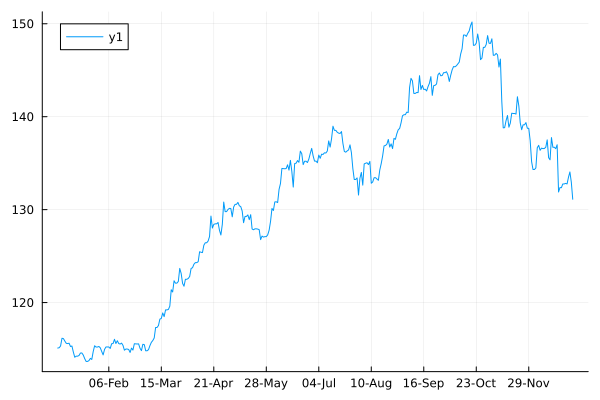

In [3]:
plot(inputs.date, inputs.usdjpy)

## パラメータの設定

辞書型(Dict)で知覚モデルと反応モデルのパラメーターを設定します。シミュレーション用なので、とりあえず適当にいれます（x1の平均の初期値は、１ドルは110円くらいじゃないという国里の雑な理解で投入など）。あまり解説もないので間違っている可能性はあるのですが，コードをみる限りは，パラメータは以下のような意味を持ちます。

- value_coupling: 異なる階層をつなぐパラメータなので $\kappa$ に対応します。
- evolution_rate: 状態の変化に関するステップサイズなので， $\omega$ に対応します。なお，最上位の場合は， $\vartheta$ を使いますが，このパッケージではevolution_rateで統一されています。
- initial_mean: 状態の分布の平均の初期値です。
- initial_precision: 状態の分布の精度（分散の逆数）の初期値です。

HGFでのランダムウォークの分散は， $exp(\kappa_{i}x_{i+1} + \omega_{i})$ であることに注意ください。指数関数を使うので，マイナスは０から１の間，１を超えると非常に大きな数になります。

In [4]:
hgf_parameters = Dict(
    ("u", "x1", "value_coupling") => 1.0,
    ("x1", "x2", "volatility_coupling") => 1.0,
    ("u", "evolution_rate") => -log(1e4),
    ("x1", "evolution_rate") => -10,
    ("x2", "evolution_rate") => -2,
    ("x1", "initial_mean") => 110,
    ("x1", "initial_precision") => 1 / (0.01),
    ("x2", "initial_mean") => 10,
    ("x2", "initial_precision") => 1 / 0.1,
);

## 知覚モデル(HGF)の用意

知覚モデル(HGF)を用意します。

知覚モデル(HGF)：円ドルレートは入力が連続なので，HierarchicalGaussianFilteringパッケージで事前に用意されているcontinuous_2levelを用います。continuous_2levelは，２階層のHGFで，入力uが連続で，状態のx1とその上の階層に変動性のx2があるモデルです。

以下のコードは，premade_hgfでperceptionオブジェクトを作っています。verbose = falseを使うと詳細の設定をしなくてもオブジェクトが作れます。

In [5]:
hgf = premade_hgf("continuous_2level", hgf_parameters, verbose = false);

## 反応モデルの用意

反応モデルを用意します。

反応モデル：円ドルレートの場合はHGFの状態がそのまま反応に使えるので，ActionModelsパッケージで事前に用意されているhgf_gaussian_actionを使います。hgf_gaussian_actionは、HGFの状態にノイズをつけて出力します。

以下のコードは，premade_agentで上記で作ったhgfを組み込んだagentオブジェクトを作っています。verbose = falseを使うと詳細の設定をしなくてもオブジェクトが作れます。

In [6]:
agent_parameters = Dict("gaussian_action_precision" => 100);
agent = premade_agent("hgf_gaussian_action", 
    hgf, 
    agent_parameters, 
    verbose = false);

## エージェントを動かしてみる

知覚モデル，反応モデル，そのパラメータの設定ができたので，あとはgive_inputs!()で入力をいれると，エージェントが動作します。

In [7]:
actions = give_inputs!(agent, inputs.usdjpy);

## 軌道をプロットする

plot_trajectory()を使って，入力(u)を緑色の丸，x1を赤色の線，エージェントの行動をオレンジ色の丸でプロットした。入力に対して，適切にx1の事後分布が調整され，行動が出力されているのがわかる。

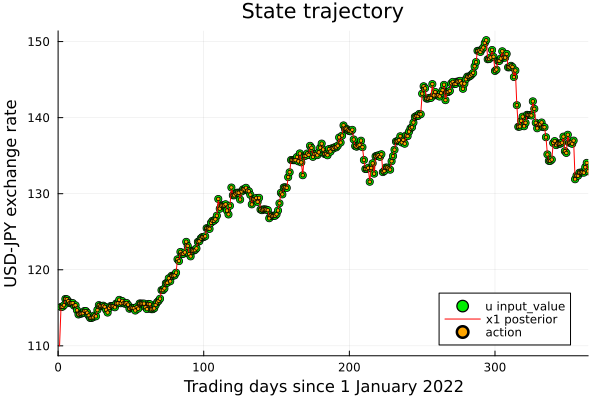

In [8]:
plot_trajectory(
    agent,
    "u",
    size = (600, 400),
    xlims = (0, 364),
    markersize = 4,
    markercolor = "green2",
    title = "HGF trajectory",
    ylabel = "USD-JPY exchange rate",
    xlabel = "Trading days since 1 January 2022",
)
plot_trajectory!(agent, ("x1", "posterior"), color = "red")
plot_trajectory!(
    agent,
    "action",
    size = (600, 400),
    xlims = (0, 364),
    markersize = 2,
    markercolor = "orange",
)

## X2の事後分布の軌道をプロットする

x1の変動性にかかわるx2の軌道もプロットできる。

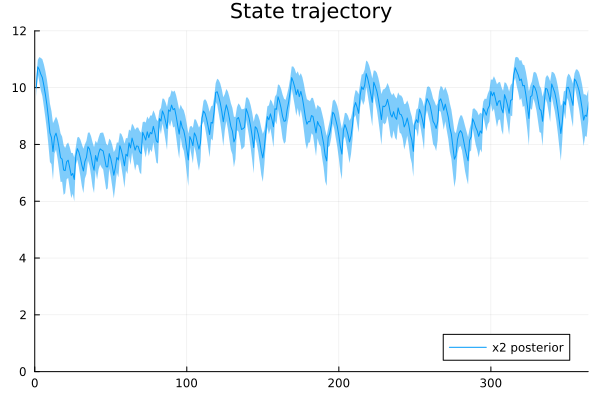

In [9]:
plot_trajectory(
    agent,
    ("x2", "posterior"),
    size = (600, 400),
    xlims = (0, 364),
    ylims = (0,12),
    markersize = 2,
    markercolor = "orange",
)

## パラメータを変更する

パラメータを変更した場合の挙動も確認します。今回は，最上位のレベル（x2）の $exp(\vartheta)$ を-2から１に変更します（つまり分散のステップサイズは0.135から2.718に変更される）。変更しても問題ない動作をしていますが，x2のレベルでは変動が大きいことがわかります。もっと大きくすると，x1のレベルにも影響が出ます。

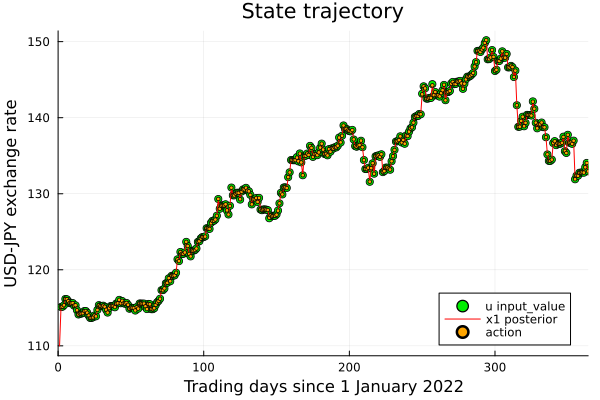

In [10]:
hgf_parameters2 = Dict(
    ("u", "x1", "value_coupling") => 1.0,
    ("x1", "x2", "volatility_coupling") => 1.0,
    ("u", "evolution_rate") => -log(1e4),
    ("x1", "evolution_rate") => -10,
    ("x2", "evolution_rate") => 1,
    ("x1", "initial_mean") => 110,
    ("x1", "initial_precision") => 1 / (0.01),
    ("x2", "initial_mean") => 10,
    ("x2", "initial_precision") => 1 / 0.1,
);

hgf2 = premade_hgf("continuous_2level", hgf_parameters2, verbose = false);
agent_parameters = Dict("gaussian_action_precision" => 100);
agent2 = premade_agent("hgf_gaussian_action", hgf2, agent_parameters, verbose = false);
actions2 = give_inputs!(agent2, inputs.usdjpy);
plot_trajectory(
    agent2,
    "u",
    size = (600, 400),
    xlims = (0, 364),
    markersize = 4,
    markercolor = "green2",
    title = "HGF trajectory",
    ylabel = "USD-JPY exchange rate",
    xlabel = "Trading days since 1 January 2022",
)
plot_trajectory!(agent2, ("x1", "posterior"), color = "red")
plot_trajectory!(
    agent2,
    "action",
    size = (600, 400),
    xlims = (0, 364),
    markersize = 2,
    markercolor = "orange",
)

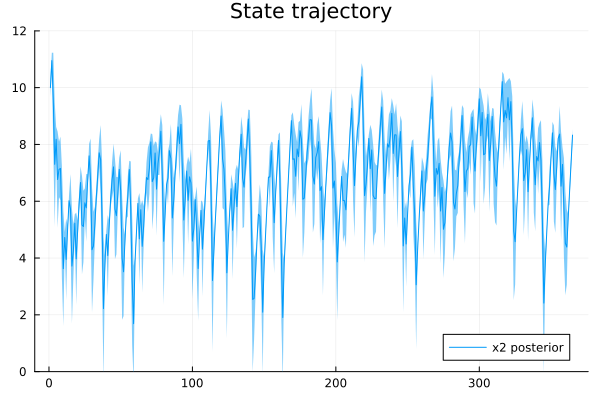

In [11]:
plot_trajectory(
    agent2,
    ("x2", "posterior"),
    size = (600, 400),
    ylims = (0,12),
    markersize = 2,
    markercolor = "orange",
)

## モデルフィッティング

今度は，モデルフィッティング（パラメータ推定）をしてみましょう！

モデルフィッティング（事前予測プロットも）では，ActionModels.jlパッケージを用います。モデルフィッティング用のfit_model()関数は，[Turing.jl(ベイズ推論用の確率的プログラミングライブラリ)](https://github.com/TuringLang/Turing.jl)を用いてパラメータ推定をします（詳細はTuring.jlも参照する必要があります）。


推定するパラメータとこちらで設定するパラメータがありますので，まず，こちらで設定するパラメータをfixed_parametersとして設定します（今回は， $\kappa$ は1に固定されています）。

In [12]:
fixed_parameters = Dict(
    ("u", "x1", "value_coupling") => 1.0,
    ("x1", "x2", "volatility_coupling") => 1.0,
    ("x1", "initial_mean") => 0,
    ("x1", "initial_precision") => 2000,
    ("x2", "initial_mean") => 110.0,
    ("x2", "initial_precision") => 600.0,
    "gaussian_action_precision" => 100,
);

続いて，推定するパラメータ（ $\omega$ ）の事前分布を以下のように設定します。

In [13]:
param_priors = Dict(
    ("u", "evolution_rate") => truncated(Normal(-10, 2), -50, 0),
    ("x1", "evolution_rate") => truncated(Normal(-10, 4), -50, 0),
    ("x2", "evolution_rate") => truncated(Normal(-4, 4), -50, 0),
);

### 事前予測シミュレーション

事前予測シミュレーションは，自分の設定した事前分布が合理的な範囲で動作するかなどを検証する上で便利です。例えば，反応時間のモデリングの場合，負の値のデータが生成されるのはおかしいので，事前分布の問題がありえます。固定パラメータと事前分布からサンプリングしてデータ生成することで，事前分布について確認することができます。今回の場合は，事前分布がせまいので，X1の軌道と一致しており，プロット上は見えなくなります。

┌ Warning: the agent has parameters which are not specified in the fixed or sampled parameters. The agent's current parameter values are used instead
└ @ ActionModels ~/.julia/packages/ActionModels/PuyrO/src/plots/plot_predictive_simulation.jl:59
┌ Warning: 4 out of 100 sampled parameters were rejected
└ @ ActionModels ~/.julia/packages/ActionModels/PuyrO/src/plots/plot_predictive_simulation.jl:147


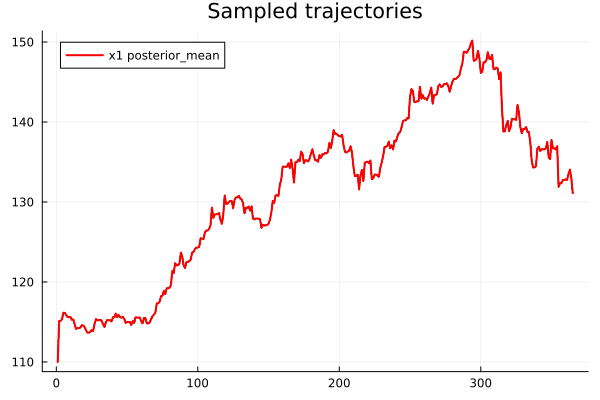

In [14]:
plot_predictive_simulation(
    param_priors,
    agent,
    inputs.usdjpy,
    ("x1", "posterior_mean");
    n_simulations = 100,
)

### fit_model()によるモデルフィッティング

fit_model()関数の引数は以下になります。

#### エージェントの情報と事前分布の引数
- agent::Agent 作成したエージェントオブジェクトを指定
- param_priors::Dict 事前分布を指定(例.priors = Dict("learning_rate" => Uniform(0, 1))。なおAgentに色々とパラメータをいれていても、ここで設定をすると推定中は上書きされる。
- inputs:Array 入力の配列
- actions::Array 反応の配列
- fixed_parameters::Dict = Dict()  推定しないパラメータを指定

#### サンプリング関連変数
- sampler = NUTS()　サンプラーの種類を指定（詳細はTuringを参照、デフォルトはNUTS()になっている)
- n_cores::Integer 計算に使うCPUのコア数を指定（デフォルトは2になる。以降デフォルトを使いますが、ご自身の解析環境に合わせて設定ください）
- n_iterations　MCMCチェーンのイテレーション（デフォルトは1000になる）
- n_chains MCMCチェーンの数（デフォルトは１になる）

#### エラー情報と欠測値を含むかどうか
- verbose falseにすると警告が消える（デフォルトはtrue）
- show_sample_rejections tureにするとサンプルがリジェクトされるたびにメッセージがでる(デフォルトはfalse)
- impute_missing_actions　trueにすると欠測した反応を推定に含める(デフォルトはfalse)


上記を踏まえて、引数を設定します。今回は、サンプリング関連変数はn_chainsだけ４に変更しています。

In [15]:
fitted_model = fit_model(
    agent,
    param_priors,
    inputs.usdjpy,
    actions,
    fixed_parameters = fixed_parameters,
    n_chains = 4,
)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:42
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:09
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:51
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:42


Chains MCMC chain (1000×15×4 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 4
Samples per chain = 1000
Wall duration     = 221.08 seconds
Compute duration  = 218.98 seconds
parameters        = ("x1", "evolution_rate"), ("u", "evolution_rate"), ("x2", "evolution_rate")
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
                parameters       mean       std   naive_se      mcse         ess      rhat   ess_per_sec 
                    Symbol    Float64   Float64    Float64   Float64     Float64   Float64       Float64 

  ("x1", "evolution_rate")   -10.0688    3.9055     0.0618    0.1361    864.7891    1.0020        3.9492
   ("u", "evolution_rate")   -10.4788    1.8943     0.0300    0.0663    717.1903    1.0047        3.2751
  ("x2", "evolution_rate")    -6.1262    2.9969     0.0474 

### MCMCチェーンの確認

plot(fit_model()の結果)でMCMCチェーンを確認できる。

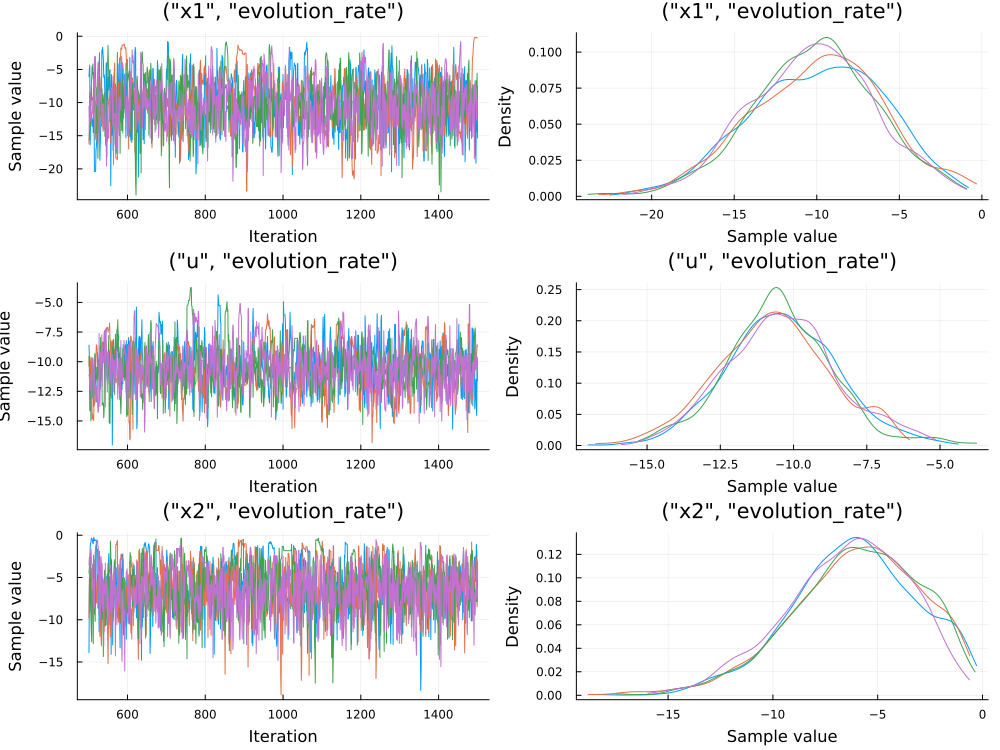

In [16]:
plot(fitted_model)

#### 事前分布と事後分布の重ね合わせプロット

plot_parameter_distribution(fit_model()の結果, 事前分布の設定)で、事前分布と事後分布の比較ができる。

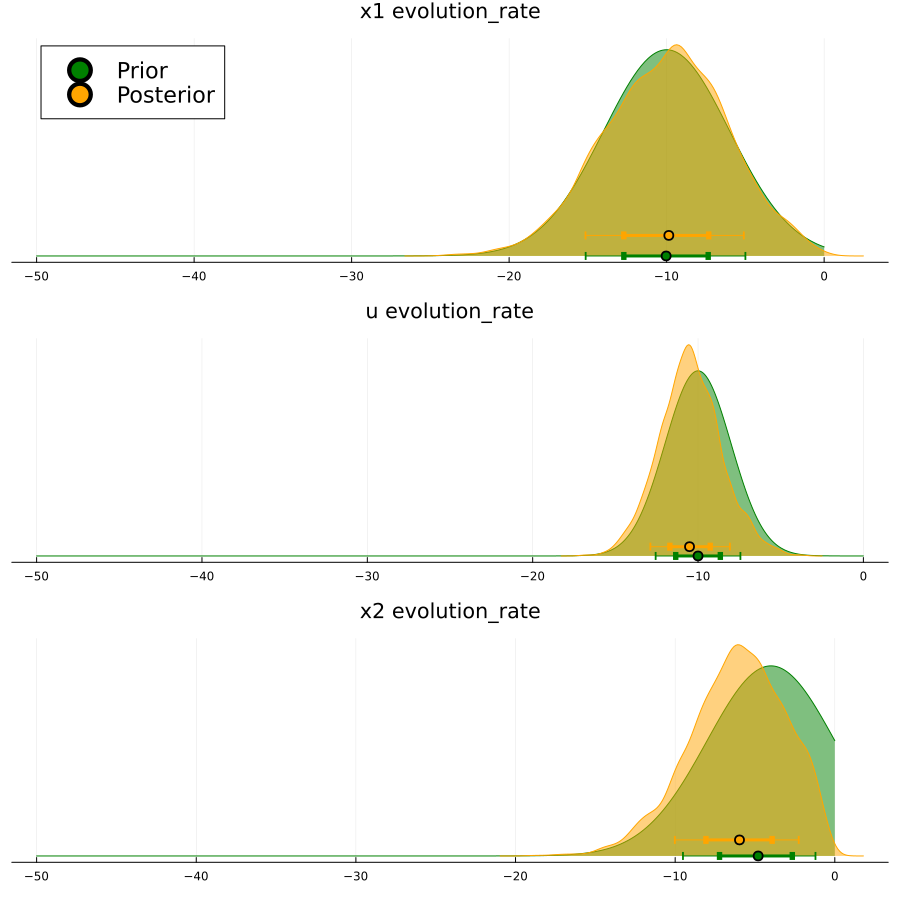

In [17]:
plot_parameter_distribution(fitted_model, param_priors)

## 事後予測シミュレーション

推定したパラメータをつかって事後予測シミュレーションもできます。

┌ Warning: the agent has parameters which are not specified in the fixed or sampled parameters. The agent's current parameter values are used instead
└ @ ActionModels ~/.julia/packages/ActionModels/PuyrO/src/plots/plot_predictive_simulation.jl:59
┌ Warning: 11 out of 100 sampled parameters were rejected
└ @ ActionModels ~/.julia/packages/ActionModels/PuyrO/src/plots/plot_predictive_simulation.jl:147


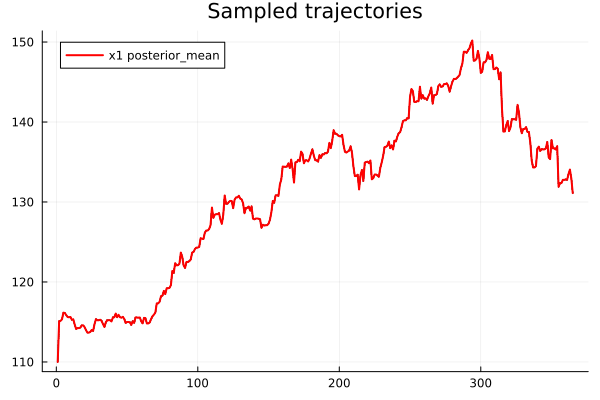

In [18]:
plot_predictive_simulation(
    fitted_model,
    agent,
    inputs.usdjpy,
    ("x1", "posterior_mean");
    n_simulations = 100,
)

## モデル比較について

ActionModelsとHierarchicalGaussianFilteringは便利なパッケージです。しかし、HGFの推定は事前分布の影響を強く受けるので、その設定は慎重に行う必要があります。現状では、HierarchicalGaussianFilteringにはモデル比較の機能はついていません(2023年2月)。WAICでモデル比較する場合は、ArviZパッケージでもできますが、Turingのモデルの方で対数尤度を出力するように設定しておく必要があります（もしくは推定されたパラメータとモデルを使って後で計算する）。組み込み関数なので、それは結構面倒なのと、[ActionModelsへのArviZの組み込みがこれから行われるような様子](https://github.com/ilabcode/ActionModels.jl/issues/25) なので、少し待つほうが良いかもしれません(国里の方でも自作関数を書いてWAICを計算をしましたが，動作が少しおかしいので本チュートリアルから除外しました)。